In [14]:
# Core
import pandas as pd
import numpy as np

# Modeling
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Visualization
import matplotlib.pyplot as plt

In [3]:
# Loading datasets datasets
df = pd.read_csv('data/train_test.csv')
val = pd.read_csv('data/val.csv')

In [4]:
# Feature Engineering
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X = X[(X[['x','y','z']] > 0).all(axis=1)].copy()
        X['volume'] = X['x'] * X['y'] * X['z']
        return X.reset_index(drop=True)

# Outlier Removal
class VolumeOutlierRemover(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        Q1 = X['volume'].quantile(0.25)
        Q3 = X['volume'].quantile(0.75)
        self.lower_ = Q1 - 1.5*(Q3-Q1)
        self.upper_ = Q3 + 1.5*(Q3-Q1)
        return self
    def transform(self, X):
        return X[(X['volume'] >= self.lower_) & (X['volume'] <= self.upper_)].reset_index(drop=True)

In [5]:
# Apply FE
fe = FeatureEngineering()
data_fe = fe.fit_transform(df)

# Apply Outlier Removal
orr = VolumeOutlierRemover()
data_clean = orr.fit_transform(data_fe)

In [6]:
# separate target
X_all = data_clean.drop('price', axis=1)
y_all = data_clean['price']

# Stratify split
X_all['carat_bin'] = pd.cut(X_all['carat'], bins=[0, .5, 1, 1.5, 2, 3, 4, np.inf], labels=False)
split = StratifiedShuffleSplit(1, test_size=0.2, random_state=42)
train_idx, test_idx = next(split.split(X_all, X_all['carat_bin']))

X_train = X_all.loc[train_idx].drop('carat_bin', axis=1)
y_train = y_all.loc[train_idx]
X_test  = X_all.loc[test_idx ].drop('carat_bin', axis=1)
y_test  = y_all.loc[test_idx]

In [7]:
# Apply FE + OR to the validation set
val_fe = fe.transform(val)
val_clean = orr.transform(val_fe)

X_val = val_clean.drop('price', axis=1)
y_val = val_clean['price']

In [8]:
y_train = np.log(y_train)
y_test  = np.log(y_test)
y_val   = np.log(y_val)

In [9]:
numerical_cols   = ['depth','table','carat','volume']
categorical_cols = ['cut','color','clarity']

# defining pipelines here
num_pipeline = Pipeline([
    ('log',   FunctionTransformer(np.log, validate=False)),
    ('scale', StandardScaler())
])

cat_pipeline = Pipeline([
    ('ord', OrdinalEncoder())
])

# Final Preprocessor
preprocessor = ColumnTransformer([
    ('num', num_pipeline,   numerical_cols),
    ('cat', cat_pipeline,   categorical_cols)
], remainder='drop')

In [10]:
# Full pipeline
full_pipeline = Pipeline([
    ('prep', preprocessor)
])

# Apply pipeline
X_train_prepared = full_pipeline.fit_transform(X_train, y_train)
X_test_prepared  = full_pipeline.transform(X_test)
X_val_prepared   = full_pipeline.transform(X_val)

In [18]:
# 1. Basic Linear Regression 
print("Training Linear Regression...")
linear_model = LinearRegression()
linear_model.fit(X_train_prepared, y_train)

Training Linear Regression...


LinearRegression()

In [19]:
# 2. Optimize RF
# print("\nOptimizing Random Forest Regressor...")
# param_grid_rf = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# rf_grid = GridSearchCV(
#     RandomForestRegressor(random_state=42, n_jobs=-1),
#     param_grid_rf,
#     cv=3,
#     scoring='r2',
#     n_jobs=-1,
#     verbose=1
# )

# rf_grid.fit(X_train_prepared, y_train)
# best_rf = rf_grid.best_estimator_
# print(f"Best Random Forest Parameters: {rf_grid.best_params_}")

best_rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train_prepared, y_train)

RandomForestRegressor(max_depth=20, min_samples_split=10, n_estimators=200,
                      n_jobs=-1, random_state=42)

In [20]:
# # 3. Ridge Regression Optimization
# print("\nOptimizing Ridge Regression...")
# param_grid_ridge = {
#     'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
# }

# ridge_grid = GridSearchCV(
#     Ridge(random_state=42),
#     param_grid_ridge,
#     cv=3,
#     scoring='r2',
#     n_jobs=-1
# )

# ridge_grid.fit(X_train_prepared, y_train)
# best_ridge = ridge_grid.best_estimator_
# print(f"Best Ridge Parameters: {ridge_grid.best_params_}")

best_ridge = Ridge(
    alpha=1.0,
    random_state=42
)
best_ridge.fit(X_train_prepared, y_train)

Ridge(random_state=42)

In [21]:
# 4. Gradient Boosting Regression Optimization
# print("\nOptimizing Gradient Boosting Regressor...")
# param_grid_gb = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 5, 7]
# }

# gb_grid = GridSearchCV(
#     GradientBoostingRegressor(random_state=42),
#     param_grid_gb,
#     cv=3,
#     scoring='r2',
#     n_jobs=-1,
#     verbose=1
# )

# gb_grid.fit(X_train_prepared, y_train)
# best_gb = gb_grid.best_estimator_
# print(f"Best Gradient Boosting Parameters: {gb_grid.best_params_}")

best_gb = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    random_state=42
)
best_gb.fit(X_train_prepared, y_train)

GradientBoostingRegressor(max_depth=7, n_estimators=200, random_state=42)

In [23]:
# 5. Evaluating all models on test and validation sets
# Linear Regression
y_test_pred_linear = linear_model.predict(X_test_prepared)
rmse_test_linear = np.sqrt(mean_squared_error(y_test, y_test_pred_linear))
r2_test_linear = r2_score(y_test, y_test_pred_linear)

y_val_pred_linear = linear_model.predict(X_val_prepared)
rmse_val_linear = np.sqrt(mean_squared_error(y_val, y_val_pred_linear))
r2_val_linear = r2_score(y_val, y_val_pred_linear)

# Best Random Forest
y_test_pred_rf = best_rf.predict(X_test_prepared)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
r2_test_rf = r2_score(y_test, y_test_pred_rf)

y_val_pred_rf = best_rf.predict(X_val_prepared)
rmse_val_rf = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))
r2_val_rf = r2_score(y_val, y_val_pred_rf)

# Best Ridge
y_test_pred_ridge = best_ridge.predict(X_test_prepared)
rmse_test_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))
r2_test_ridge = r2_score(y_test, y_test_pred_ridge)

y_val_pred_ridge = best_ridge.predict(X_val_prepared)
rmse_val_ridge = np.sqrt(mean_squared_error(y_val, y_val_pred_ridge))
r2_val_ridge = r2_score(y_val, y_val_pred_ridge)

# Best Gradient Boosting
y_test_pred_gb = best_gb.predict(X_test_prepared)
rmse_test_gb = np.sqrt(mean_squared_error(y_test, y_test_pred_gb))
r2_test_gb = r2_score(y_test, y_test_pred_gb)

y_val_pred_gb = best_gb.predict(X_val_prepared)
rmse_val_gb = np.sqrt(mean_squared_error(y_val, y_val_pred_gb))
r2_val_gb = r2_score(y_val, y_val_pred_gb)

print("\n===== Model Performance Summary =====")
print(f"Linear Regression Test RMSE: {rmse_test_linear:.4f}")
print(f"Linear Regression Test R^2: {r2_test_linear:.4f}")
print(f"Linear Regression Validation RMSE: {rmse_val_linear:.4f}")
print(f"Linear Regression Validation R^2: {r2_val_linear:.4f}")

print(f"\nBest Random Forest Test RMSE: {rmse_test_rf:.4f}")
print(f"Best Random Forest Test R^2: {r2_test_rf:.4f}")
print(f"Best Random Forest Validation RMSE: {rmse_val_rf:.4f}")
print(f"Best Random Forest Validation R^2: {r2_val_rf:.4f}")

print(f"\nBest Ridge Regression Test RMSE: {rmse_test_ridge:.4f}")
print(f"Best Ridge Regression Test R^2: {r2_test_ridge:.4f}")
print(f"Best Ridge Regression Validation RMSE: {rmse_val_ridge:.4f}")
print(f"Best Ridge Regression Validation R^2: {r2_val_ridge:.4f}")

print(f"\nBest Gradient Boosting Test RMSE: {rmse_test_gb:.4f}")
print(f"Best Gradient Boosting Test R^2: {r2_test_gb:.4f}")
print(f"Best Gradient Boosting Validation RMSE: {rmse_val_gb:.4f}")
print(f"Best Gradient Boosting Validation R^2: {r2_val_gb:.4f}")


===== Model Performance Summary =====
Linear Regression Test RMSE: 0.2088
Linear Regression Test R^2: 0.9547
Linear Regression Validation RMSE: 0.2077
Linear Regression Validation R^2: 0.9554

Best Random Forest Test RMSE: 0.1062
Best Random Forest Test R^2: 0.9883
Best Random Forest Validation RMSE: 0.0781
Best Random Forest Validation R^2: 0.9937

Best Ridge Regression Test RMSE: 0.2088
Best Ridge Regression Test R^2: 0.9547
Best Ridge Regression Validation RMSE: 0.2077
Best Ridge Regression Validation R^2: 0.9554

Best Gradient Boosting Test RMSE: 0.0980
Best Gradient Boosting Test R^2: 0.9900
Best Gradient Boosting Validation RMSE: 0.0854
Best Gradient Boosting Validation R^2: 0.9925


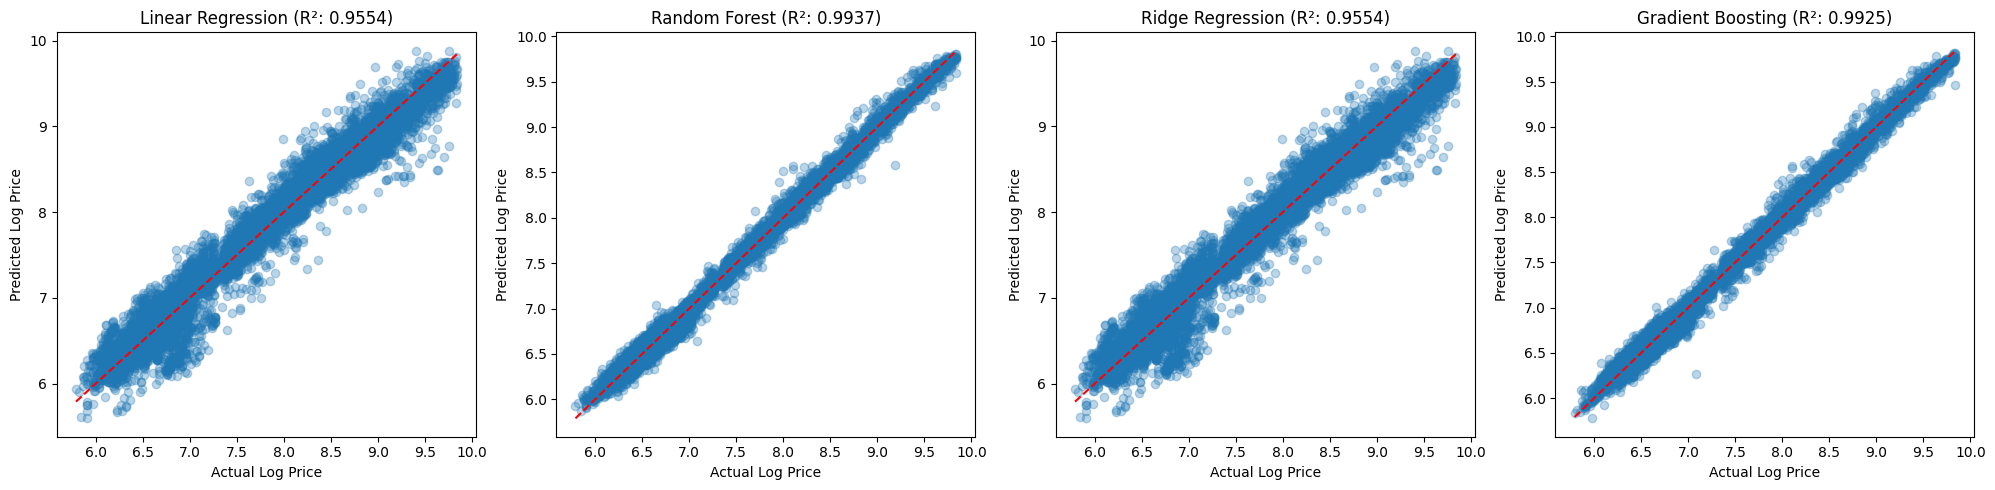

In [24]:
# 6. Plot actual vs predicted for validation set
plt.figure(figsize=(20, 5))

# Linear Regression plot
plt.subplot(1, 4, 1)
plt.scatter(y_val, y_val_pred_linear, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual Log Price")
plt.ylabel("Predicted Log Price")
plt.title(f"Linear Regression (R²: {r2_val_linear:.4f})")

# Random Forest plot
plt.subplot(1, 4, 2)
plt.scatter(y_val, y_val_pred_rf, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual Log Price")
plt.ylabel("Predicted Log Price")
plt.title(f"Random Forest (R²: {r2_val_rf:.4f})")

# Ridge Regression plot
plt.subplot(1, 4, 3)
plt.scatter(y_val, y_val_pred_ridge, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual Log Price")
plt.ylabel("Predicted Log Price")
plt.title(f"Ridge Regression (R²: {r2_val_ridge:.4f})")

# Gradient Boosting plot
plt.subplot(1, 4, 4)
plt.scatter(y_val, y_val_pred_gb, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual Log Price")
plt.ylabel("Predicted Log Price")
plt.title(f"Gradient Boosting (R²: {r2_val_gb:.4f})")

plt.tight_layout()
plt.show()

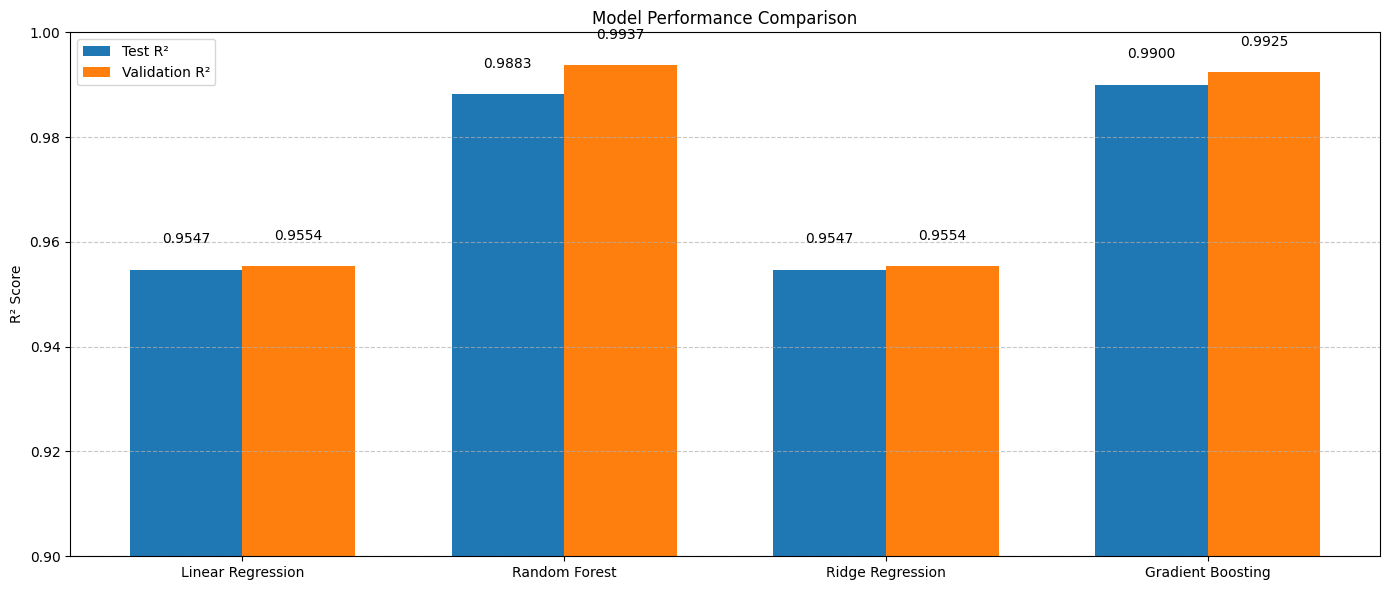

In [25]:
# 7. Plot model comparison
models = ['Linear Regression', 'Random Forest', 'Ridge Regression', 'Gradient Boosting']
test_r2 = [r2_test_linear, r2_test_rf, r2_test_ridge, r2_test_gb]
val_r2 = [r2_val_linear, r2_val_rf, r2_val_ridge, r2_val_gb]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(14, 6))
plt.bar(x - width/2, test_r2, width, label='Test R²')
plt.bar(x + width/2, val_r2, width, label='Validation R²')

plt.ylabel('R² Score')
plt.title('Model Performance Comparison')
plt.xticks(x, models)
plt.ylim(0.9, 1.0)  # Focusing on the range where differences are visible
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(test_r2):
    plt.text(i - width/2, v + 0.005, f'{v:.4f}', ha='center')

for i, v in enumerate(val_r2):
    plt.text(i + width/2, v + 0.005, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

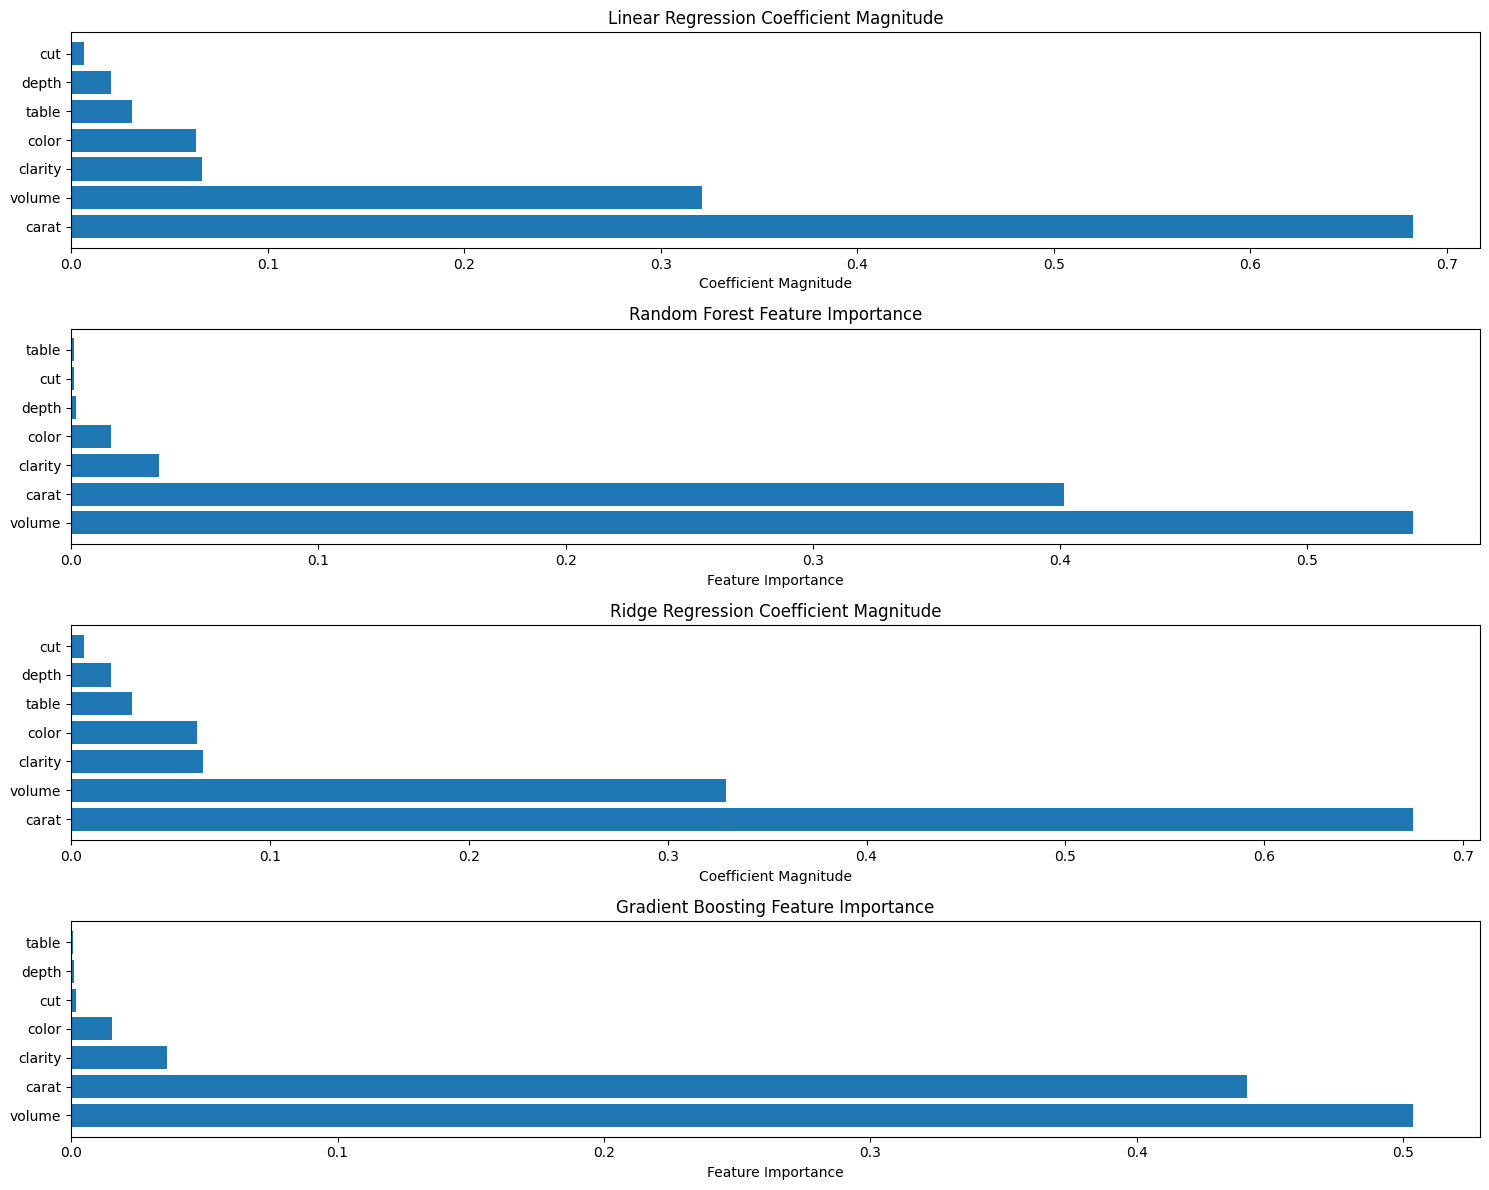

In [26]:
# 8. Feature importance comparison
feature_names = list(numerical_cols + categorical_cols)

# For Linear Regression (absolute coefficients)
linear_coefs = np.abs(linear_model.coef_)
linear_indices = np.argsort(linear_coefs)[::-1]

# For Random Forest
rf_importances = best_rf.feature_importances_
rf_indices = np.argsort(rf_importances)[::-1]

# For Ridge Regression
ridge_coefs = np.abs(best_ridge.coef_)
ridge_indices = np.argsort(ridge_coefs)[::-1]

# For Gradient Boosting
gb_importances = best_gb.feature_importances_
gb_indices = np.argsort(gb_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(15, 12))

# Linear Regression coefficients
plt.subplot(4, 1, 1)
plt.barh(range(len(linear_indices)), linear_coefs[linear_indices])
plt.yticks(range(len(linear_indices)), [feature_names[i] for i in linear_indices])
plt.xlabel("Coefficient Magnitude")
plt.title("Linear Regression Coefficient Magnitude")

# Random Forest importances
plt.subplot(4, 1, 2)
plt.barh(range(len(rf_indices)), rf_importances[rf_indices])
plt.yticks(range(len(rf_indices)), [feature_names[i] for i in rf_indices])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")

# Ridge Regression coefficients
plt.subplot(4, 1, 3)
plt.barh(range(len(ridge_indices)), ridge_coefs[ridge_indices])
plt.yticks(range(len(ridge_indices)), [feature_names[i] for i in ridge_indices])
plt.xlabel("Coefficient Magnitude")
plt.title("Ridge Regression Coefficient Magnitude")

# Gradient Boosting importances
plt.subplot(4, 1, 4)
plt.barh(range(len(gb_indices)), gb_importances[gb_indices])
plt.yticks(range(len(gb_indices)), [feature_names[i] for i in gb_indices])
plt.xlabel("Feature Importance")
plt.title("Gradient Boosting Feature Importance")

plt.tight_layout()

In [27]:
# transforming log predictions back to original scale
def unlog_predictions(y_log_pred):
    return np.exp(y_log_pred)

print("Evaluating models on original price scale (dollars)...")

# getting original y values 
y_test_orig = np.exp(y_test)
y_val_orig = np.exp(y_val)

# converting predictions back to original scale
y_test_pred_linear_orig = unlog_predictions(y_test_pred_linear)
y_test_pred_rf_orig = unlog_predictions(y_test_pred_rf)
y_test_pred_ridge_orig = unlog_predictions(y_test_pred_ridge)
y_test_pred_gb_orig = unlog_predictions(y_test_pred_gb)

y_val_pred_linear_orig = unlog_predictions(y_val_pred_linear)
y_val_pred_rf_orig = unlog_predictions(y_val_pred_rf)
y_val_pred_ridge_orig = unlog_predictions(y_val_pred_ridge)
y_val_pred_gb_orig = unlog_predictions(y_val_pred_gb)

# metrics in original scale
# RMSE
rmse_test_linear_orig = np.sqrt(mean_squared_error(y_test_orig, y_test_pred_linear_orig))
rmse_test_rf_orig = np.sqrt(mean_squared_error(y_test_orig, y_test_pred_rf_orig))
rmse_test_ridge_orig = np.sqrt(mean_squared_error(y_test_orig, y_test_pred_ridge_orig))
rmse_test_gb_orig = np.sqrt(mean_squared_error(y_test_orig, y_test_pred_gb_orig))

rmse_val_linear_orig = np.sqrt(mean_squared_error(y_val_orig, y_val_pred_linear_orig))
rmse_val_rf_orig = np.sqrt(mean_squared_error(y_val_orig, y_val_pred_rf_orig))
rmse_val_ridge_orig = np.sqrt(mean_squared_error(y_val_orig, y_val_pred_ridge_orig))
rmse_val_gb_orig = np.sqrt(mean_squared_error(y_val_orig, y_val_pred_gb_orig))

# R²
r2_test_linear_orig = r2_score(y_test_orig, y_test_pred_linear_orig)
r2_test_rf_orig = r2_score(y_test_orig, y_test_pred_rf_orig)
r2_test_ridge_orig = r2_score(y_test_orig, y_test_pred_ridge_orig)
r2_test_gb_orig = r2_score(y_test_orig, y_test_pred_gb_orig)

r2_val_linear_orig = r2_score(y_val_orig, y_val_pred_linear_orig)
r2_val_rf_orig = r2_score(y_val_orig, y_val_pred_rf_orig)
r2_val_ridge_orig = r2_score(y_val_orig, y_val_pred_ridge_orig)
r2_val_gb_orig = r2_score(y_val_orig, y_val_pred_gb_orig)

# Mean Absolute Percentage Error (MAPE) in original scale
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_test_linear = mape(y_test_orig, y_test_pred_linear_orig)
mape_test_rf = mape(y_test_orig, y_test_pred_rf_orig)
mape_test_ridge = mape(y_test_orig, y_test_pred_ridge_orig)
mape_test_gb = mape(y_test_orig, y_test_pred_gb_orig)

mape_val_linear = mape(y_val_orig, y_val_pred_linear_orig)
mape_val_rf = mape(y_val_orig, y_val_pred_rf_orig)
mape_val_ridge = mape(y_val_orig, y_val_pred_ridge_orig)
mape_val_gb = mape(y_val_orig, y_val_pred_gb_orig)

print("\n===== Model Performance in Original Price Scale (dollars) =====")
print(f"Linear Regression Test RMSE: ${rmse_test_linear_orig:.2f}")
print(f"Linear Regression Test R^2: {r2_test_linear_orig:.4f}")
print(f"Linear Regression Test MAPE: {mape_test_linear:.2f}%")
print(f"Linear Regression Validation RMSE: ${rmse_val_linear_orig:.2f}")
print(f"Linear Regression Validation R^2: {r2_val_linear_orig:.4f}")
print(f"Linear Regression Validation MAPE: {mape_val_linear:.2f}%")

print(f"\nRandom Forest Test RMSE: ${rmse_test_rf_orig:.2f}")
print(f"Random Forest Test R^2: {r2_test_rf_orig:.4f}")
print(f"Random Forest Test MAPE: {mape_test_rf:.2f}%")
print(f"Random Forest Validation RMSE: ${rmse_val_rf_orig:.2f}")
print(f"Random Forest Validation R^2: {r2_val_rf_orig:.4f}")
print(f"Random Forest Validation MAPE: {mape_val_rf:.2f}%")

print(f"\nRidge Regression Test RMSE: ${rmse_test_ridge_orig:.2f}")
print(f"Ridge Regression Test R^2: {r2_test_ridge_orig:.4f}")
print(f"Ridge Regression Test MAPE: {mape_test_ridge:.2f}%")
print(f"Ridge Regression Validation RMSE: ${rmse_val_ridge_orig:.2f}")
print(f"Ridge Regression Validation R^2: {r2_val_ridge_orig:.4f}")
print(f"Ridge Regression Validation MAPE: {mape_val_ridge:.2f}%")

print(f"\nGradient Boosting Test RMSE: ${rmse_test_gb_orig:.2f}")
print(f"Gradient Boosting Test R^2: {r2_test_gb_orig:.4f}")
print(f"Gradient Boosting Test MAPE: {mape_test_gb:.2f}%")
print(f"Gradient Boosting Validation RMSE: ${rmse_val_gb_orig:.2f}")
print(f"Gradient Boosting Validation R^2: {r2_val_gb_orig:.4f}")
print(f"Gradient Boosting Validation MAPE: {mape_val_gb:.2f}%")

Evaluating models on original price scale (dollars)...

===== Model Performance in Original Price Scale (dollars) =====
Linear Regression Test RMSE: $1055.52
Linear Regression Test R^2: 0.9123
Linear Regression Test MAPE: 15.73%
Linear Regression Validation RMSE: $1042.56
Linear Regression Validation R^2: 0.9152
Linear Regression Validation MAPE: 15.86%

Random Forest Test RMSE: $504.50
Random Forest Test R^2: 0.9800
Random Forest Test MAPE: 8.01%
Random Forest Validation RMSE: $359.96
Random Forest Validation R^2: 0.9899
Random Forest Validation MAPE: 5.84%

Ridge Regression Test RMSE: $1055.51
Ridge Regression Test R^2: 0.9123
Ridge Regression Test MAPE: 15.73%
Ridge Regression Validation RMSE: $1042.58
Ridge Regression Validation R^2: 0.9152
Ridge Regression Validation MAPE: 15.86%

Gradient Boosting Test RMSE: $466.04
Gradient Boosting Test R^2: 0.9829
Gradient Boosting Test MAPE: 7.34%
Gradient Boosting Validation RMSE: $382.84
Gradient Boosting Validation R^2: 0.9886
Gradient Boo

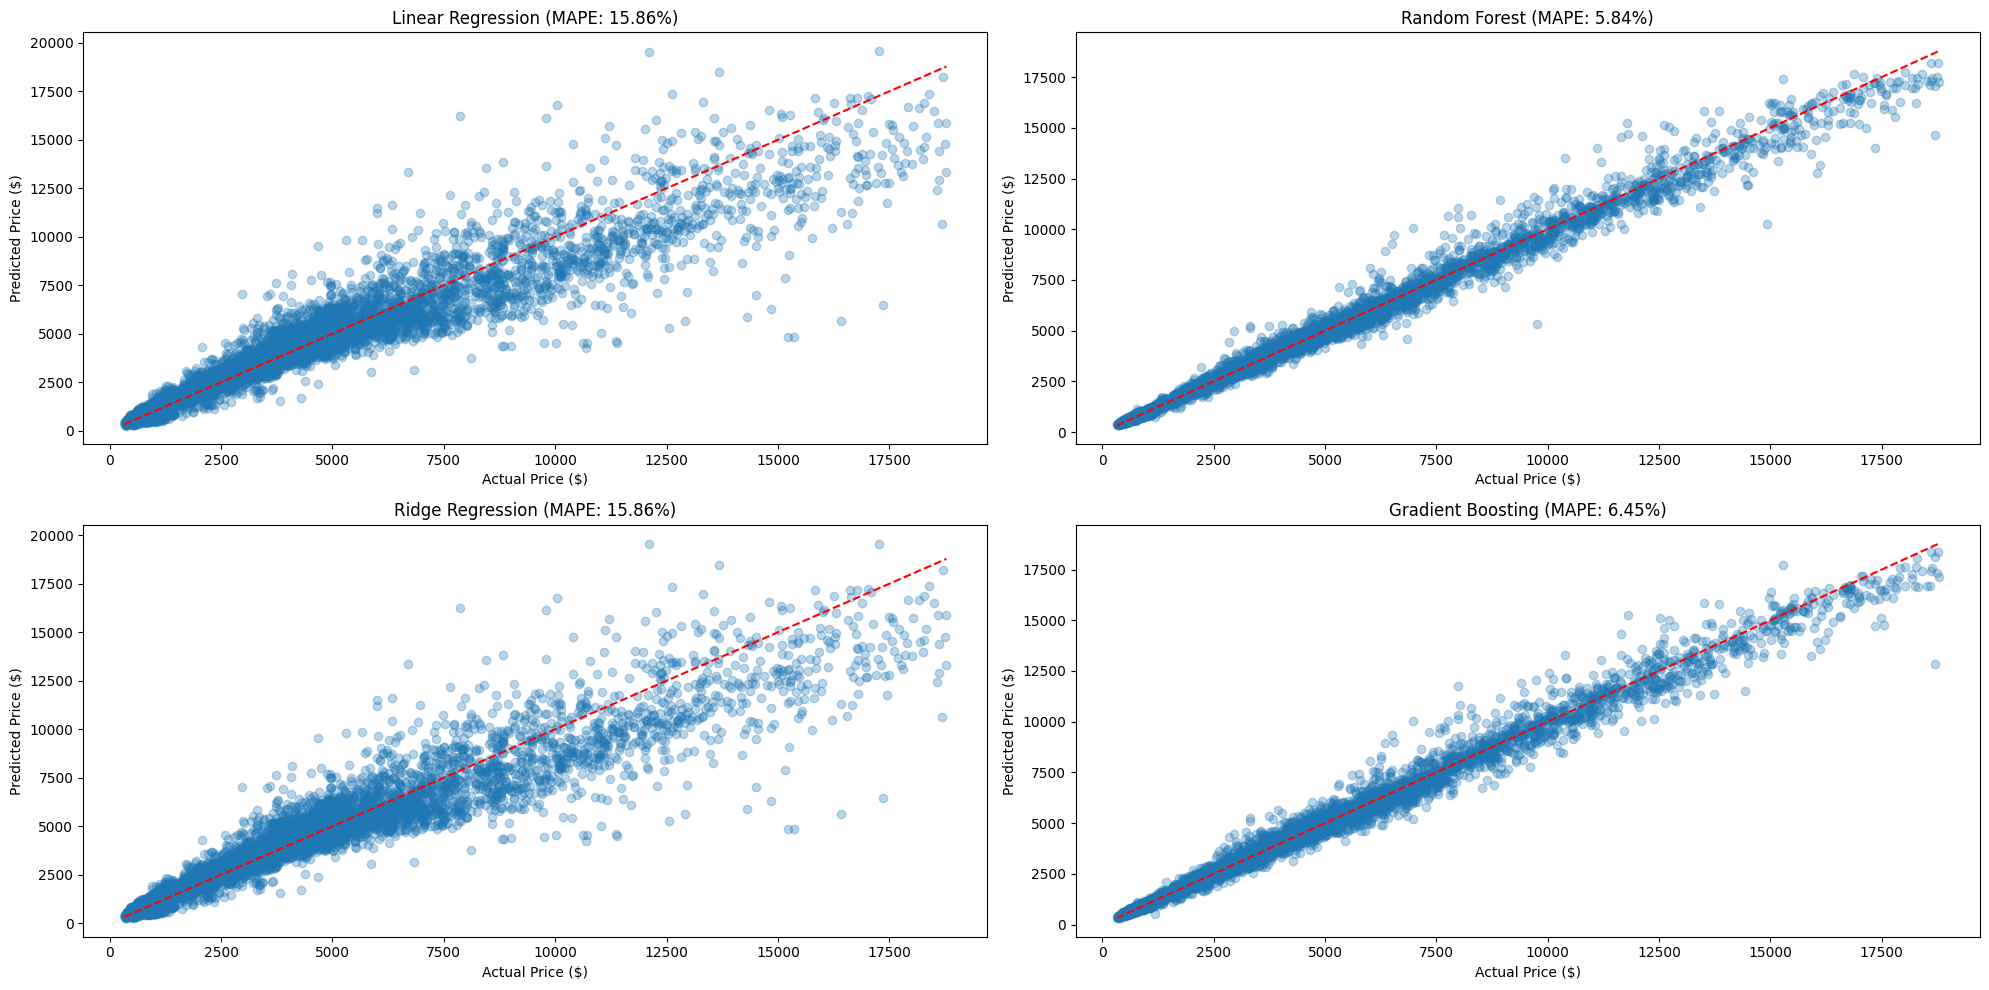

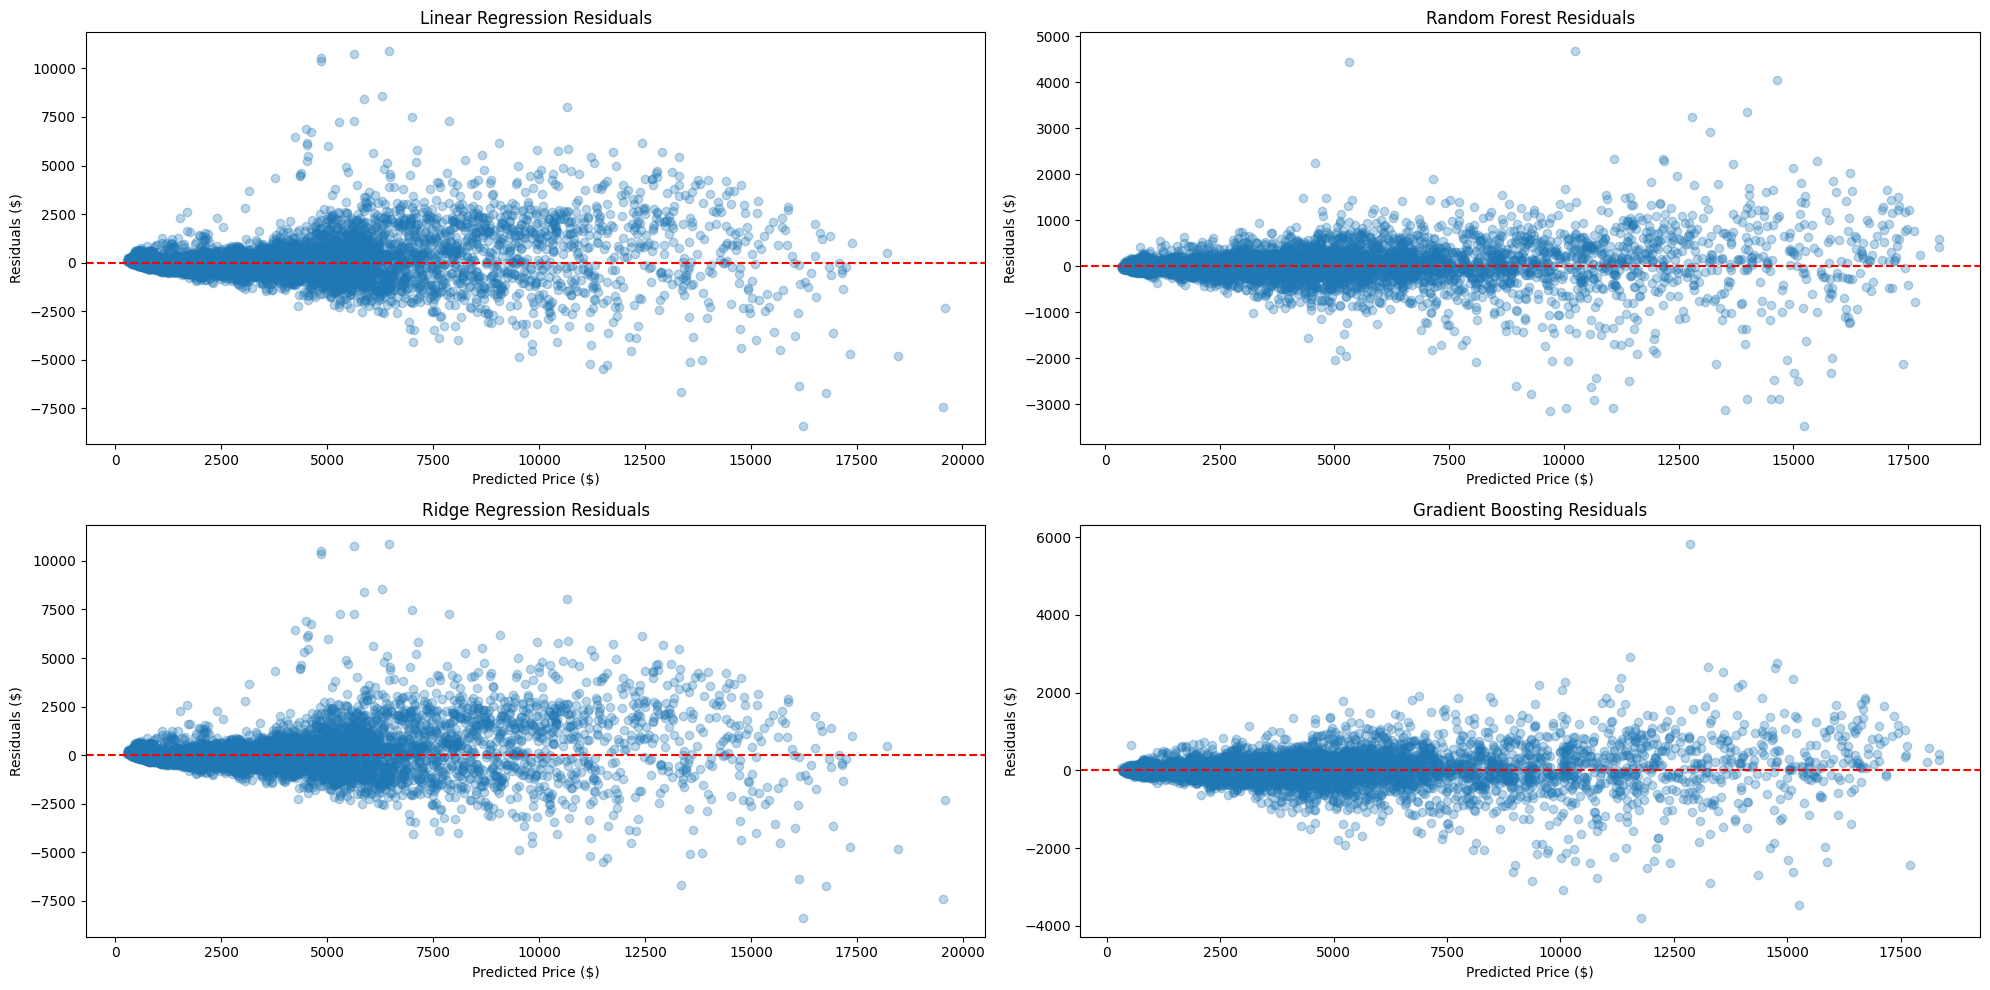


===== Error Analysis by Price Range (Validation Set) =====

Model		Range		Count	Avg Price	MAPE
Linear Regression	$0-$1K	2303	$705.43	18.03%
Linear Regression	$1K-$5K	3975	$2619.14	14.74%
Linear Regression	$5K-$10K	1500	$6907.36	14.85%
Linear Regression	$10K-$20K	633	$13036.21	17.43%
Random Forest	$0-$1K	2303	$705.43	7.73%
Random Forest	$1K-$5K	3975	$2619.14	5.17%
Random Forest	$5K-$10K	1500	$6907.36	5.13%
Random Forest	$10K-$20K	633	$13036.21	4.90%
Ridge Regression	$0-$1K	2303	$705.43	18.03%
Ridge Regression	$1K-$5K	3975	$2619.14	14.74%
Ridge Regression	$5K-$10K	1500	$6907.36	14.85%
Ridge Regression	$10K-$20K	633	$13036.21	17.43%
Gradient Boosting	$0-$1K	2303	$705.43	7.81%
Gradient Boosting	$1K-$5K	3975	$2619.14	6.11%
Gradient Boosting	$5K-$10K	1500	$6907.36	5.87%
Gradient Boosting	$10K-$20K	633	$13036.21	5.03%


In [30]:
# plotting actual vs predicted in original scale
plt.figure(figsize=(20, 10))

# Linear Regression plot
plt.subplot(2, 2, 1)
plt.scatter(y_val_orig, y_val_pred_linear_orig, alpha=0.3)
plt.plot([y_val_orig.min(), y_val_orig.max()], [y_val_orig.min(), y_val_orig.max()], 'r--')
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title(f"Linear Regression (MAPE: {mape_val_linear:.2f}%)")

# Random Forest plot
plt.subplot(2, 2, 2)
plt.scatter(y_val_orig, y_val_pred_rf_orig, alpha=0.3)
plt.plot([y_val_orig.min(), y_val_orig.max()], [y_val_orig.min(), y_val_orig.max()], 'r--')
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title(f"Random Forest (MAPE: {mape_val_rf:.2f}%)")

# Ridge Regression plot
plt.subplot(2, 2, 3)
plt.scatter(y_val_orig, y_val_pred_ridge_orig, alpha=0.3)
plt.plot([y_val_orig.min(), y_val_orig.max()], [y_val_orig.min(), y_val_orig.max()], 'r--')
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title(f"Ridge Regression (MAPE: {mape_val_ridge:.2f}%)")

# Gradient Boosting plot
plt.subplot(2, 2, 4)
plt.scatter(y_val_orig, y_val_pred_gb_orig, alpha=0.3)
plt.plot([y_val_orig.min(), y_val_orig.max()], [y_val_orig.min(), y_val_orig.max()], 'r--')
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title(f"Gradient Boosting (MAPE: {mape_val_gb:.2f}%)")

plt.tight_layout()
plt.show()

# Examine residuals in original scale
plt.figure(figsize=(20, 10))

# Calculate residuals
residuals_linear = y_val_orig - y_val_pred_linear_orig
residuals_rf = y_val_orig - y_val_pred_rf_orig
residuals_ridge = y_val_orig - y_val_pred_ridge_orig
residuals_gb = y_val_orig - y_val_pred_gb_orig

# Linear Regression residuals
plt.subplot(2, 2, 1)
plt.scatter(y_val_pred_linear_orig, residuals_linear, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Price ($)")
plt.ylabel("Residuals ($)")
plt.title("Linear Regression Residuals")

# Random Forest residuals
plt.subplot(2, 2, 2)
plt.scatter(y_val_pred_rf_orig, residuals_rf, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Price ($)")
plt.ylabel("Residuals ($)")
plt.title("Random Forest Residuals")

# Ridge Regression residuals
plt.subplot(2, 2, 3)
plt.scatter(y_val_pred_ridge_orig, residuals_ridge, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Price ($)")
plt.ylabel("Residuals ($)")
plt.title("Ridge Regression Residuals")

# Gradient Boosting residuals
plt.subplot(2, 2, 4)
plt.scatter(y_val_pred_gb_orig, residuals_gb, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Price ($)")
plt.ylabel("Residuals ($)")
plt.title("Gradient Boosting Residuals")

plt.tight_layout()
plt.show()

# error distribution by price range
def analyze_errors_by_price_range(y_true, y_pred, model_name):
    # Create price ranges
    price_ranges = [0, 1000, 5000, 10000, 20000, float('inf')]
    range_labels = ['$0-$1K', '$1K-$5K', '$5K-$10K', '$10K-$20K', '$20K+']
    
    results = []
    
    for i in range(len(price_ranges)-1):
        # Get indices for this price range
        idx = (y_true >= price_ranges[i]) & (y_true < price_ranges[i+1])
        
        if np.sum(idx) > 0:  # If we have samples in this range
            range_mape = mape(y_true[idx], y_pred[idx])
            range_count = np.sum(idx)
            range_avg_price = np.mean(y_true[idx])
            
            results.append({
                'Range': range_labels[i],
                'Count': range_count,
                'Avg Price': f"${range_avg_price:.2f}",
                'MAPE': f"{range_mape:.2f}%",
                'Model': model_name
            })
    
    return results


# analyzing errors by price range for each model
linear_errors = analyze_errors_by_price_range(y_val_orig, y_val_pred_linear_orig, "Linear Regression")
rf_errors = analyze_errors_by_price_range(y_val_orig, y_val_pred_rf_orig, "Random Forest")
ridge_errors = analyze_errors_by_price_range(y_val_orig, y_val_pred_ridge_orig, "Ridge Regression")
gb_errors = analyze_errors_by_price_range(y_val_orig, y_val_pred_gb_orig, "Gradient Boosting")

print("\n===== Error Analysis by Price Range (Validation Set) =====")
all_errors = linear_errors + rf_errors + ridge_errors + gb_errors

print("\nModel\t\tRange\t\tCount\tAvg Price\tMAPE")
for err in all_errors:
   print(f"{err['Model']}\t{err['Range']}\t{err['Count']}\t{err['Avg Price']}\t{err['MAPE']}")

In [12]:
import joblib

# retraining the best random forest on entire dataset
X_all = pd.concat([X_train, X_test, X_val])
y_all = pd.concat([y_train, y_test, y_val])

X_all_preprocessed = full_pipeline.fit_transform(X_all)

final_rf_model = RandomForestRegressor(
    n_estimators=200,  
    max_depth=20,    # using best parameters from GridSearch
    random_state=42,
    n_jobs=-1
)
final_rf_model.fit(X_all_preprocessed, y_all)

RandomForestRegressor(max_depth=20, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [16]:
# a few test samples
sample_diamonds = [
    # 1 carat, ideal cut diamond
    {'carat': 1.0, 'cut': 'Ideal', 'color': 'G', 'clarity': 'VS1', 
     'depth': 61.2, 'table': 56.0, 'x': 6.49, 'y': 6.53, 'z': 3.99},
    
    # 2 carat, premium cut diamond
    {'carat': 2.0, 'cut': 'Premium', 'color': 'E', 'clarity': 'VS2', 
     'depth': 62.3, 'table': 58.0, 'x': 8.15, 'y': 8.22, 'z': 5.11}
]

sample_df = pd.DataFrame(sample_diamonds)

sample_fe = fe.transform(sample_df)
sample_clean = orr.transform(sample_fe)
sample_prepared = full_pipeline.transform(sample_clean)

log_prices = final_rf_model.predict(sample_prepared)
prices = np.exp(log_prices)

for i, (diamond, price) in enumerate(zip(sample_diamonds, prices)):
    print(f"\nSample Diamond {i+1}:")
    for key, value in diamond.items():
        print(f"  {key}: {value}")
    print(f"  Predicted Price: ${price:.2f}")


Sample Diamond 1:
  carat: 1.0
  cut: Ideal
  color: G
  clarity: VS1
  depth: 61.2
  table: 56.0
  x: 6.49
  y: 6.53
  z: 3.99
  Predicted Price: $7279.15


In [17]:
# Saving the model, preprocessing pipeline ad feature engineering classes 
joblib.dump(final_rf_model, 'diamond_rf_model.joblib')
joblib.dump(full_pipeline, 'diamond_preprocessing_pipeline.joblib')
joblib.dump(fe, 'feature_engineering.joblib')
joblib.dump(orr, 'outlier_remover.joblib')

['outlier_remover.joblib']